<a href="https://colab.research.google.com/github/LenaVolzhina/playing-with-neural-networks/blob/master/DL_chapter_5_autoencoders_for_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Начинаем с просто избыточного автокодировщика

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

Гипер-параметры сети:

In [0]:
batch_size = 64
latent_space = 128
learning_rate = 0.1

Однослойный автокодировщик

In [0]:
# weights
ae_weights = {
  "encoder_w": tf.Variable(
    tf.truncated_normal([784, latent_space], stddev=0.1)
  ),
  "encoder_b": tf.Variable(
    tf.truncated_normal([latent_space], stddev=0.1)
  ),
  "decoder_w": tf.Variable(
    tf.truncated_normal([latent_space, 784], stddev=0.1)
  ),
  "decoder_b": tf.Variable(
    tf.truncated_normal([784], stddev=0.1)
  )
}

In [0]:
# tensors
ae_input = tf.placeholder(tf.float32, [batch_size, 784])
hidden = tf.nn.sigmoid(
  tf.matmul(ae_input, ae_weights["encoder_w"]) + ae_weights["encoder_b"]
)
visible_logits = (
  tf.matmul(hidden, ae_weights["decoder_w"]) + ae_weights["decoder_b"]
)
visible = tf.nn.sigmoid(visible_logits)

In [5]:
# cross-entropy
ae_cost = tf.reduce_mean(
  tf.nn.sigmoid_cross_entropy_with_logits(logits=visible_logits, labels=ae_input)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# optimize with AdaGrad
optimizer = tf.train.AdagradOptimizer(learning_rate)
ae_op = optimizer.minimize(ae_cost)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# learn
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(10000):
  x_batch, _ = mnist.train.next_batch(batch_size)
  sess.run(ae_op, feed_dict={ae_input: x_batch})

Посчитаю ошибку

Пришлось сэмплить, потому что ранее захардкодили размер батча

In [15]:
test_sample_idx = np.random.choice(np.arange(len(mnist.test.images)), size=64)   # harcoded
sample = mnist.test.images[test_sample_idx]
print(sess.run(
  ae_cost,
  feed_dict={ae_input: sample}
))

0.22638842


# TODO: запустить код ниже

# Разреженный автокодировщик

In [0]:
# вес регуляризации в лоссе
rho = 0.05   # целевая доля активаций
beta = 1.0

# тензор для регуляризации
data_rho = tf.reduce_mean(hidden, 0)
reg_cost = (
  - tf.reduce_mean(tf.log(data_rho/rho) * rho +
  tf.log((1-data_rho)/(1-rho)) * (1-rho))
)

In [0]:
total_cost = ae_cost + beta * reg_cost

Можно после обучения попробовать обнулять внутренние значения в скрытом слое меньше порога и притом видеть вполне внятные результаты

Полезные свойства:
* если обнулять редко или слабо используемые веса, можно сильно сократить модель
* внутренние фильтры имеют явную и понятную семантику

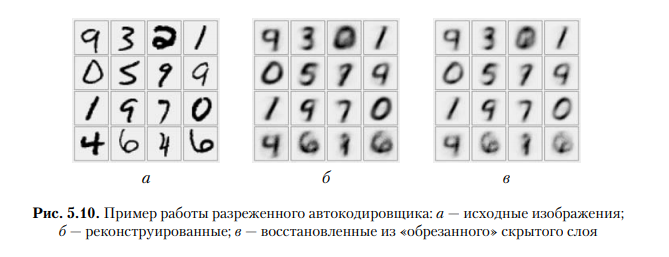

### Отрисовка внутренних фильтров

Для этого максимизируем произведение xW по x с ограничением на суммарные значения входов

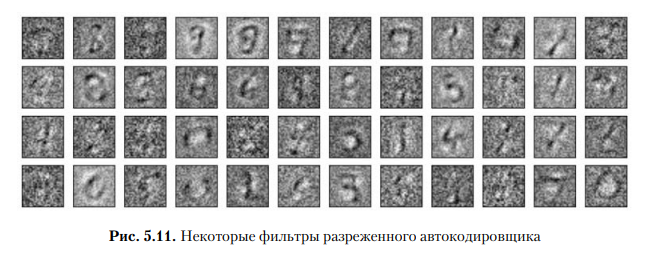

# Шумоподавляющий автокодировщик

In [0]:
noisy_input = tf.placeholder(tf.float32, [batch_size, 784])

hidden = tf.nn.sigmoid(
  tf.matmul(noisy_input, ae_weights["encoder_w"])
  + ae_weights["encoder_b"]
)

Вероятность выкидывания в 30% интуитивно кажется очень уж большой, но в реальности шум именно такого порядка работает хорошо

In [0]:
noise_prob = 0.3

In [0]:
for i in xrange(updates):
  x_batch, _ = mnist.train.next_batch(batch_size)
  noise_mask = np.random.uniform(0., 1., [batch_size, 784]) < noise_prob
  noisy_batch = x_batch.copy()
  noisy_batch[noise_mask] = 0.0
  sess.run(ae_op, feed_dict={ae_input: x_batch, noisy_input: noisy_batch})

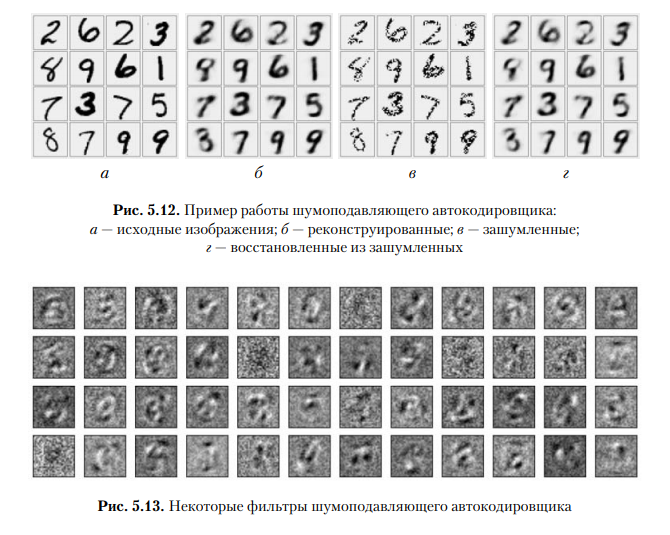

# Свёрточный автокодировщик

Нужно придумать операцию разворачивания для декодировщика.

Операция деконволюции: разворачиваем число обратно в матрицу kxk. Аккуратно учитываем шаг свертки и дополнение нулями

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
batch_size, learning_rate = 64, 0.01

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
# веса как у просто сверточной сети
ae_weights = {
  "conv": tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
  "b_hidden": tf.Variable(tf.truncated_normal([4], stddev=0.1)),
  # размерности tf сам транспонирует
  "deconv": tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
  "b_visible": tf.Variable(tf.truncated_normal([1], stddev=0.1))
}

In [0]:
input_shape = tf.stack([batch_size, 28, 28, 1])

In [0]:
ae_input = tf.placeholder(tf.float32, [batch_size, 784])
images = tf.reshape(ae_input, [-1, 28, 28, 1])

In [0]:
hidden_logits = tf.nn.conv2d(
  # тут был баг
  images, ae_weights["conv"], strides=[1, 2, 2, 1], padding="SAME"
) + ae_weights["b_hidden"]

hidden = tf.nn.sigmoid(hidden_logits)

In [0]:
visible_logits = tf.nn.conv2d_transpose(hidden, 
  ae_weights["deconv"], input_shape, strides=[1, 2, 2, 1], padding="SAME"
) + ae_weights["b_visible"]

visible = tf.nn.sigmoid(visible_logits)

In [0]:
optimizer = tf.train.AdagradOptimizer(learning_rate)
conv_cost = tf.reduce_mean(
  tf.nn.sigmoid_cross_entropy_with_logits(logits=visible_logits, labels=images)
)
conv_op = optimizer.minimize(conv_cost)

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for i in range(100000):
  x_batch, _ = mnist.train.next_batch(batch_size)
  sess.run(conv_op, feed_dict={ae_input: x_batch})

In [46]:
# считаю ошибку
x_batch, _ = mnist.test.next_batch(batch_size)
sess.run(conv_cost, feed_dict={ae_input: x_batch})

0.07861494

Вообще тут есть чему удивляться!

В этой сетке всего 205 весов, а в полносвязном было больше 300к! Полносвязная с легкостью могла бы эмулировать эту мелочь.

Проблемы полносвязной возникают из-за большого числа параметров:
* времени для обучения требуется сильно больше
* нужно сильно больше данных (даже если добавить регуляризацию)

Саму архитектуру сверточных слоев можно считать формой регуляризации для данных с пространственной структурой

# Добавление второго слоя (не запускала)

In [0]:
ae_weights = {
  "conv1": tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
  "b_conv1": tf.Variable(tf.truncated_normal([4], stddev=0.1)),
  "conv2": tf.Variable(tf.truncated_normal([5, 5, 4, 16], stddev=0.1)),
  "b_hidden": tf.Variable(tf.truncated_normal([16], stddev=0.1)),
  "deconv1": tf.Variable(tf.truncated_normal([5, 5, 4, 16], stddev=0.1)),
  "b_deconv": tf.Variable(tf.truncated_normal([4], stddev=0.1)),
  "deconv2": tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
  "b_visible": tf.Variable(tf.truncated_normal([1], stddev=0.1)),
}

In [0]:
h1_shape = tf.pack([batch_size, 14, 14, 4])

In [0]:
images = tf.reshape(ae_input, [-1, 28, 28, 1])

conv_h1_logits = tf.nn.conv2d(
  images, ae_weights["conv1"], strides=[1, 2, 2, 1], padding="SAME"
) + ae_weights["b_conv1"]
conv_h1 = tf.nn.relu(conv_h1_logits)

hidden_logits = tf.nn.conv2d(
  conv_h1, ae_weights["conv2"], strides=[1, 2, 2, 1], padding="SAME"
) + ae_weights["b_hidden"]
hidden = tf.nn.relu(hidden_logits)

deconv_h1_logits = tf.nn.conv2d_transpose(hidden,
  ae_weights["deconv1"], h1_shape, strides=[1, 2, 2, 1], padding="SAME"
) + ae_weights["b_deconv"]
deconv_h1 = tf.nn.relu(deconv_h1_logits)

visible_logits = tf.nn.conv2d_transpose(deconv_h1,
  ae_weights["deconv2"], input_shape, strides=[1, 2, 2, 1], padding="SAME"
) + ae_weights["b_visible"]
visible = tf.nn.sigmoid(visible_logits)

Все остальное можно оставить без изменений. В этот раз мы использовали
1025 весов, и уже примерно после 10 000 итераций обучения ошибка на тестовых
данных падает до 0,08, а в результате продолжительного обучения останавливается на уровне около 0,07

Можно сказать, что MNIST мы таким сверточным автокодировщиком окончательно «победили», примерно так же, как раньше в этой главе достигли
сверточной сетью очень высокой точности классификации.